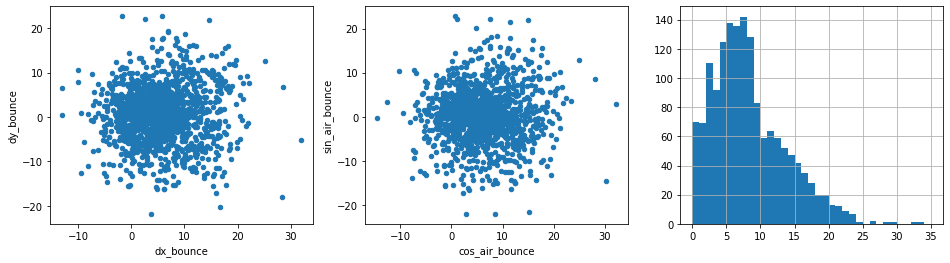

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Activation, Concatenate, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split


bounce_data = pd.read_csv('../ReducedData/BounceTrainingData/BounceFeatures.csv',index_col=0)

fig,ax = plt.subplots(1,3,figsize=(16,4))
bounce_data.plot.scatter(x='dx_bounce',y='dy_bounce',ax=ax[0])
bounce_data.plot.scatter(x='cos_air_bounce',y='sin_air_bounce',ax=ax[1])
bounce_data['dist_bounce'].hist(bins=np.arange(0,36,1),ax=ax[2])
plt.show()

In [2]:
def standardize(x,mu,sigma):
    return (x-mu)/sigma

def log_bivariate_norm(x,y, mu_x,mu_y, sigma_x,sigma_y, rho):
    x_stand = standardize(x,mu_x,sigma_x)
    y_stand = standardize(y,mu_y,sigma_y)
    return tf.math.log(2*np.pi)+tf.math.log(sigma_x)+tf.math.log(sigma_y)+tf.math.log(1-rho**2)/2 + 1/(2*(1-rho**2))*(x_stand**2 + y_stand**2 + 2*rho*x_stand*y_stand)

def custom_loss(y_true,y_pred):
    loss = log_bivariate_norm(y_true[:,0],y_true[:,1],y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3],y_pred[:,4])
    return tf.reduce_mean(loss, axis=-1)


def get_NN(n_features):
    inputs = Input(shape=n_features,name='Inputs')
    x = Dense(8, activation='elu')(inputs)
    x = Dense(8, activation='tanh')(x)
    
    mu = Dense(2)(x)
    sig = Dense(2, activation = 'softplus')(x)#(lambda x: tf.keras.activations.elu(x)+1))(x)
    rho = Dense(1, activation = 'tanh')(x)
    outputs = Concatenate()([mu,sig,rho])
    
    model = Model(inputs=inputs, outputs=outputs)
    opt = optimizers.Adam(learning_rate=0.003)
    
    model.compile(loss=custom_loss,optimizer=opt)
    
    return model

get_NN(1).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 8)            16          ['Inputs[0][0]']                 
                                                                                                  
 dense_1 (Dense)                (None, 8)            72          ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            18          ['dense_1[0][0]']                
                                                                                              

In [3]:
features_raw = bounce_data[['x_fb','dy_air','hangTime','v_c','v_field_ratio']]
#.iloc[:,2:12]
#[['gameId','playId']]
features_stand = features_raw.copy()

ft_stats = np.zeros((features_raw.shape[1],2))
for i in range(features_raw.shape[1]):
    ft_stats[i,0] = features_raw.iloc[:,i].mean()
    ft_stats[i,1] = features_raw.iloc[:,i].std()
    features_stand.iloc[:,i] = standardize(features_stand.iloc[:,i],*ft_stats[i])
    
ft_array = features_stand.values
bounce_outcome = bounce_data[['cos_air_bounce','sin_air_bounce']].values
#[['dx_bounce','dy_bounce']].values

In [5]:
#pd.DataFrame(ft_stats,columns=['mean','std']).to_csv('../ReducedData/bounce_training_statistics.csv',index=False)

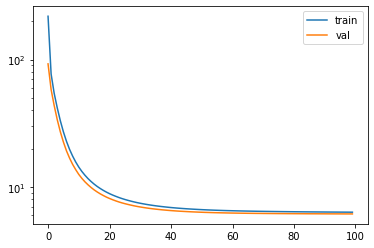

In [12]:
X_train, X_test, y_train, y_test = train_test_split(ft_array,bounce_outcome,test_size=0.2)

model = get_NN(features_raw.shape[1])
history = model.fit(
    X_train,
    y_train,
    batch_size = 32,
    epochs=100,
    verbose=0,
    validation_data = (X_test,y_test)
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.legend(['train','val'])
plt.show()

In [13]:
results = pd.concat([pd.DataFrame(bounce_outcome),pd.DataFrame(model.predict(ft_array))],axis=1)
#results = pd.concat([pd.DataFrame(y_test),pd.DataFrame(model.predict(X_test))],axis=1)
#results = pd.concat([pd.DataFrame(y_train),pd.DataFrame(model.predict(X_train))],axis=1)
results.columns=['v', 'vp', 'mu_v', 'mu_vp', 'sig_v', 'sig_vp', 'rho']

num_vect = np.zeros((len(results),2))
for i in range(len(results)):
    w,v = np.linalg.eig(np.array([[(results['sig_v']**2).iloc[i], (results['rho']*results['sig_v']*results['sig_vp']).iloc[i]],
          [(results['rho']*results['sig_v']*results['sig_vp']).iloc[i], (results['sig_vp']**2).iloc[i]]]))

    mu = np.array([results['mu_v'].iloc[i],results['mu_vp'].iloc[i]])

    num_vect[i,0],num_vect[i,1] = np.dot(bounce_outcome[i]-mu,v[:,0])/np.sqrt(w[0]),np.dot(bounce_outcome[i]-mu,v[:,1])/np.sqrt(w[1])

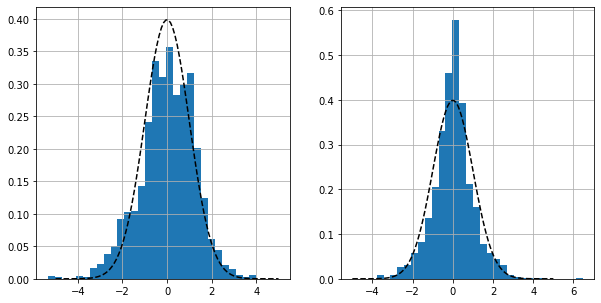

,pc_1,pc_2
count,1567.000000,1567.000000
mean,0.014159,0.021375
std,1.220337,1.006418
min,-5.340693,-3.789391
25%,-0.696854,-0.525526
50%,0.050545,0.035045
75%,0.886178,0.543364
max,4.007925,6.469582


In [14]:
num_df = pd.DataFrame(num_vect,columns=['pc_1','pc_2'])

x=np.linspace(-5,5,100)

nbins=30

fig,ax = plt.subplots(1,2,figsize=(10,5))
num_df['pc_1'].hist(bins=nbins,ax=ax[0],density=True)
num_df['pc_2'].hist(bins=nbins,ax=ax[1],density=True)
ax[0].plot(x,1/np.sqrt(2*np.pi)*np.exp(-x**2/2),'k--')
ax[1].plot(x,1/np.sqrt(2*np.pi)*np.exp(-x**2/2),'k--')
plt.show()

display(num_df.describe())

In [8]:
test_res = bounce_data.copy()

test_res['x_air'] = test_res['x_punt']+test_res['dx_air']
test_res['y_air'] = test_res['y_punt']+test_res['dy_air']
test_res['x_to_ez'] = 110-test_res['x_air']
test_res['y_nearest_sl'] = (80/3 - np.abs(80/3 - test_res['y_air']))*np.sign(test_res['y_air']-80/3)
test_res_exp = pd.concat((test_res,results[['mu_v','mu_vp','sig_v','sig_vp','rho']]),axis=1)
test_res_exp

,gameId,playId,x_fb,y_fb,x_punt,y_punt,hangTime,dx_air,dy_air,dist_air,...,sin_air_bounce,x_air,y_air,x_to_ez,y_nearest_sl,mu_v,mu_vp,sig_v,sig_vp,rho
0,2018090600,872,45,29.95,31.24,31.11,4.35,65.21,7.90,65.69,...,8.802474,96.45,39.01,13.55,14.323333,5.550858,0.168801,5.036191,5.198114,-0.051015
1,2018090600,1850,41,23.36,27.30,24.63,4.53,72.21,-14.84,73.72,...,1.250195,99.51,9.79,10.49,-9.790000,5.753724,0.302584,5.300103,5.339900,-0.051159
2,2018090600,3026,50,23.94,36.10,23.22,4.66,48.98,18.39,52.32,...,-6.154300,85.08,41.61,24.92,11.723333,5.158223,-0.425377,4.837735,5.199360,0.036360
3,2018090600,3736,31,25.59,17.47,26.64,4.20,54.40,19.56,57.81,...,7.990749,71.87,46.20,38.13,7.133333,5.916528,0.430274,5.291739,5.308462,0.066938
4,2018090900,575,36,23.63,22.18,24.70,4.20,69.41,24.50,73.61,...,0.557235,91.59,49.20,18.41,4.133333,5.727781,0.424651,5.059812,5.042388,0.023491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2021010314,209,51,23.56,36.77,24.47,4.63,66.21,-6.96,66.57,...,3.428337,102.98,17.51,7.02,-17.510000,5.142456,-0.237464,4.891331,5.231169,-0.089171
1563,2021010314,527,45,23.71,30.77,24.57,3.24,49.73,-14.28,51.74,...,10.799930,80.50,10.29,29.50,-10.290000,6.483671,0.751864,5.980659,5.639084,0.019196
1564,2021010314,2689,62,23.90,47.81,24.59,4.25,58.65,2.54,58.70,...,0.627056,106.46,27.13,3.54,26.203333,4.786654,-0.124342,4.523935,4.719421,-0.071049
1565,2021010314,3395,32,23.87,18.08,25.05,4.62,60.13,-23.92,64.71,...,-3.623166,78.21,1.13,31.79,-1.130000,5.900460,0.378247,5.430281,5.442205,-0.007616


In [9]:
from scipy.integrate import nquad

# def biv_norm(x,y, mx,my, sx,sy, r):
#     x_stand = standardize(x,mx,sx)
#     y_stand = standardize(y,my,sy)
#     return 1/(2*np.pi*sx*sy*np.sqrt(1-r**2)) * np.exp(-1/(2*(1-r**2))*(x_stand**2+y_stand**2+2*r*x_stand*y_stand))

# def rotated_biv_norm(x,y, mx,my, sx,sy, r, ctheta,stheta):
#     x_rot = x*ctheta + y*stheta
#     y_rot = y*ctheta - x*stheta
#     return biv_norm(x_rot,y_rot, mx,my, sx,sy, r)

def get_bivnorm(mx,my, sx,sy, r):
    def biv_norm(x,y):
        x_stand = standardize(x,mx,sx)
        y_stand = standardize(y,my,sy)
        return 1/(2*np.pi*sx*sy*np.sqrt(1-r**2)) * np.exp(-1/(2*(1-r**2))*(x_stand**2+y_stand**2+2*r*x_stand*y_stand))
    return biv_norm

def get_rot_pdf(mx,my, sx,sy, r, ctheta,stheta):
    pdf = get_bivnorm(mx,my, sx,sy, r)
    def rotated_biv_norm(x,y):
        x_rot = x*ctheta + y*stheta
        y_rot = y*ctheta - x*stheta
        return pdf(x_rot,y_rot)
    return rotated_biv_norm

In [10]:
samp = test_res_exp.sample()[['x_to_ez','y_nearest_sl','dx_air','dy_air','mu_v','mu_vp','sig_v','sig_vp','rho']]
display(samp)

def y_oob(y_togo):
    ranges = [[-np.inf,y_togo],[y_togo,np.inf]]
    if y_togo>0:
        return ranges
    return [ranges[1],ranges[0]]

def tb_xbound(y):
    slope = samp['x_to_ez']/samp['y_nearest_sl']
    temp = np.maximum(samp.values[0,0],(slope*(y-samp['y_nearest_sl'])+samp['x_to_ez']).values[0])
    return [temp,np.inf]

def oob_xbound(y):
    slope = (samp['x_to_ez']/samp['y_nearest_sl']).values[0]
    temp = (samp['x_to_ez']).values[0]#(slope*(y-samp['y_nearest_sl'])+samp['x_to_ez']).values[0]#
    return [-np.inf,temp]

def oob_xbound(y):
    slope = (samp['x_to_ez']/samp['y_nearest_sl']).values[0]
    temp = (slope*(y-samp['y_nearest_sl'])+samp['x_to_ez']).values[0]
    return [(samp['x_to_ez']).values[0],temp]
      
bounds = y_oob(samp.values[0,1])
cos = (samp['dx_air']/np.sqrt(samp['dx_air']**2+samp['dy_air']**2)).fillna(0)
sin = (samp['dy_air']/np.sqrt(samp['dx_air']**2+samp['dy_air']**2)).fillna(0)

rotated_PDF = get_rot_pdf(*samp.values[0,4:],cos.values[0],sin.values[0])

p_ip = nquad(rotated_PDF, [[-np.inf,samp.values[0,0]],bounds[0]])[0]
p_tb = nquad(rotated_PDF, [tb_xbound,[-np.inf,np.inf]])[0]
p_oob = nquad(rotated_PDF,[[-np.inf,samp.values[0,0]],bounds[1]])[0] + nquad(rotated_PDF,[oob_xbound,bounds[1]])[0]

print('P(InPlay): ' + str(p_ip))
print('P(TB): ' + str(p_tb))
print('P(OOB): ' + str(p_oob))
print('Total Probability: ' + str(p_ip+p_tb+p_oob))

pd.read_csv('../data/plays.csv').merge(pd.DataFrame(bounce_data.iloc[samp.index[0]][['gameId','playId']]).T)

,x_to_ez,y_nearest_sl,dx_air,dy_air,mu_v,mu_vp,sig_v,sig_vp,rho
989,18.49,-8.03,45.6,-14.76,4.556993,-0.395187,4.555253,4.815677,-0.024749


P(InPlay): 0.9045942385222843
P(TB): 0.0009352779544349954
P(OOB): 0.09447048342256084
Total Probability: 0.9999999998992801


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2019120811,1928,"(3:58) D.Colquitt punts 28 yards to NE 22, Cen...",2,4,6,KC,Punt,Downed,29926.0,...,NaN,NaN,NaN,7,17,NaN,28.0,NaN,28,60


In [11]:
def get_rot_ExpX(mx,my, sx,sy, r, ctheta,stheta):
    pdf = get_bivnorm(mx,my, sx,sy, r)
    def rotated_expX(x,y):
        x_rot = x*ctheta + y*stheta
        y_rot = y*ctheta - x*stheta
        return x * pdf(x_rot,y_rot)
    return rotated_expX

def get_rot_truncatedExpX(mx,my, sx,sy, r, ctheta,stheta, y_thres):
    pdf = get_bivnorm(mx,my, sx,sy, r)
    def rotated_truncexpX(x,y):
        x_rot = x*ctheta + y*stheta
        y_rot = y*ctheta - x*stheta
        return x*y_thres/y * pdf(x_rot,y_rot)
    return rotated_truncexpX

avg_x_loc = get_rot_ExpX(*samp.values[0,4:],cos.values[0],sin.values[0])
trunc_avg_x_loc = get_rot_truncatedExpX(*samp.values[0,4:],cos.values[0],sin.values[0],samp.values[0,1])

print('E(X|InPlay) = ' + str(nquad(avg_x_loc,[[-np.inf,samp.values[0,0]],bounds[0]])[0]/p_ip))
print('E(X|TB) = ' + str(nquad(avg_x_loc,[tb_xbound,[-np.inf,np.inf]])[0]/p_tb))
print('E(X|OOB) = ' + str((nquad(trunc_avg_x_loc,[[-np.inf,samp.values[0,0]],bounds[1]])[0] + nquad(trunc_avg_x_loc,[oob_xbound,bounds[1]])[0])/p_oob))

E(X|InPlay) = 4.243133861036762
E(X|TB) = 19.78151758134892
E(X|OOB) = 3.0614989553767793


In [116]:
#model.save('./Models/MDN_BivariateNorm.h5')